# Kaczmarek Kacper
Jakiś wstęp potem



---
# Procesowanie sygnału
#### 1. Zaciągnięcie danych z bazy https://physionet.org/content/gaitpdb/1.0.0/
#### 2. Zaczytanie danych
#### 3. Przedstawienie danych
---

### Zaczytanie pakietów

In [19]:
import pandas as pd
import utils
import importlib
importlib.reload(utils)
print('Packages imported')

Packages imported


### Zaczytanie danych

#### Zaczytanie metadanych

In [20]:
import pandas as pd
patients = pd.read_csv('Data/demographics.txt', sep='\\t')

C:\Users\kacperk\AppData\Local\Temp\ipykernel_3484\2100386468.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  patients = pd.read_csv('Data/demographics.txt', sep='\\t')


#### Zaczytanie danych o pacjentach

In [21]:
import importlib
import pandas as pd
importlib.reload(utils)

col_names = ['SUM', 'FILENAME']
data_file_colum_names = ['Time', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8','R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'Force_Left', 'Force_Right']
sums = pd.read_csv('Data/SHA256SUMS.txt', header=None, sep=' ', names=col_names)
all_filenames = sums['FILENAME']
filenames = all_filenames[all_filenames.str.contains(r'\d.txt$')]
records = {}
for filename in filenames:
    patientID = utils.getPatientID(filename)
    measureNumber = utils.getMeasureNumber(filename)
    if patientID not in records:
        records[patientID] = {}
    records[patientID][f'data{measureNumber}'] = pd.read_csv(f'Data/{filename}', header=None, sep='\t', names=data_file_colum_names)

### Prezentacja danych

#### Przykład zdrowego i chorego i rozkład sił na lewej i prawej stopie

There is 12119 records in healthy
There is 12119 records in parkinson


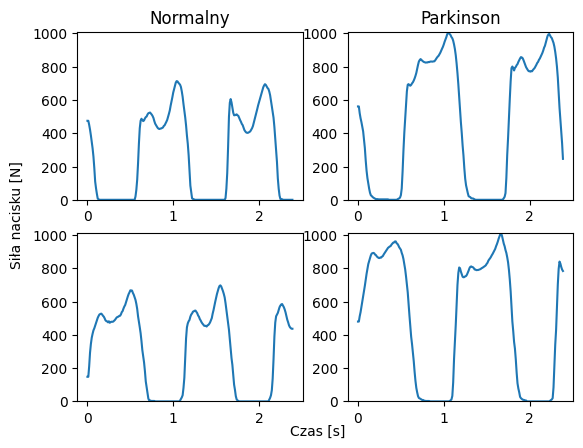

In [22]:
import matplotlib.pyplot as plt
healthy_patient_id = "GaCo16"
parkinson_patient_id = "GaPt26"
sample_number = 240

healthy_record = records[healthy_patient_id]["data1"]
parkinson_record = records[parkinson_patient_id]["data1"]

print( f'There is {len(healthy_record)} records in healthy')
x_healthy_left = healthy_record.Time.head(sample_number)
y_healthy_left = healthy_record.Force_Left.head(sample_number)
x_healthy_right = healthy_record.Time.head(sample_number)
y_healthy_right = healthy_record.Force_Right.head(sample_number)

print( f'There is {len(parkinson_record)} records in parkinson')
x_parkinson_left = parkinson_record.Time.head(sample_number)
y_parkinson_left = parkinson_record.Force_Left.head(sample_number)
x_parkinson_right = parkinson_record.Time.head(sample_number)
y_parkinson_right = parkinson_record.Force_Right.head(sample_number)

y_lim_value = pd.concat([y_healthy_left, y_healthy_right, y_parkinson_left, y_parkinson_right]).max()

fig, axs = plt.subplots(2, 2)
healthy_plot_left = axs[0,0]
healthy_plot_left.set_title('Normalny')
healthy_plot_left.plot(x_healthy_left, y_healthy_left)
healthy_plot_left.set_ylim(0, y_lim_value)
parkinson_plot_left = axs[0,1]
parkinson_plot_left.set_title('Parkinson')
parkinson_plot_left.plot(x_parkinson_left, y_parkinson_left)
parkinson_plot_left.set_ylim(0, y_lim_value)
healthy_plot_right = axs[1,0]
healthy_plot_right.plot(x_healthy_right, y_healthy_right)
healthy_plot_right.set_ylim(0, y_lim_value)
parkinson_plot_right = axs[1,1]
parkinson_plot_right.plot(x_parkinson_right, y_parkinson_right)
parkinson_plot_right.set_ylim(0, y_lim_value)
fig.text(0.5, 0.04, 'Czas [s]', ha='center')
fig.text(0.02, 0.5, 'Siła nacisku [N]', va='center', rotation='vertical')

plt.savefig("plots/gait-comparison.pdf", format="pdf", bbox_inches="tight")

#### Każdy czujnik dla zdrowego i chorego

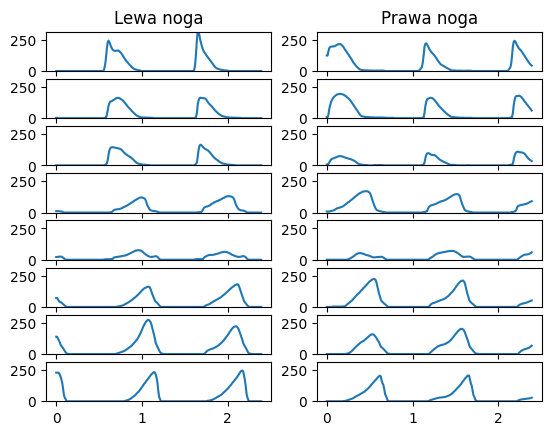

In [23]:
import utils
healthy_patient_id = "GaCo16"

healthy_record = records[healthy_patient_id]["data1"]

utils.createAllSensorPlot(healthy_record, 'healthy_all_sensors', sample_number)

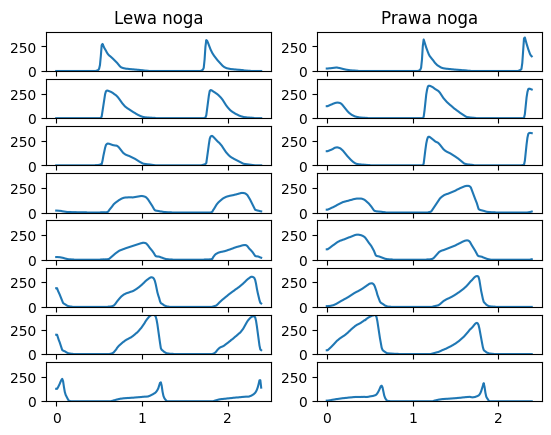

In [24]:
import utils
parkinson_patient_id = "GaPt26"

parkinson_record = records[parkinson_patient_id]["data1"]

utils.createAllSensorPlot(parkinson_record, 'parkinson_all_sensors', sample_number)

#### Wyliczenie najmniejszej porcji danych chodu

In [25]:
sample_len = float("inf")
for key, value in records.items():
    record = value['data1']
    sample_len = min(len(record.Time), sample_len)

print(sample_len)

4034


### Pokazanie zachowań kroków na podstawie czujnika prawej stopy

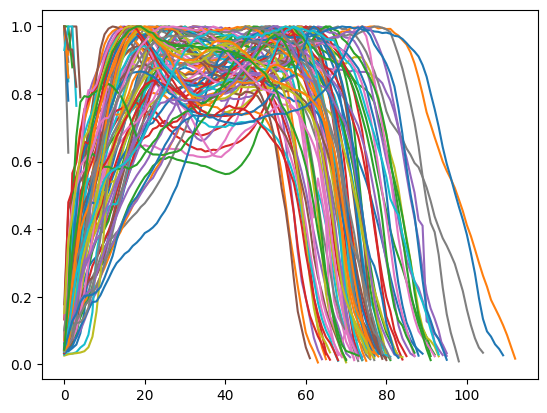

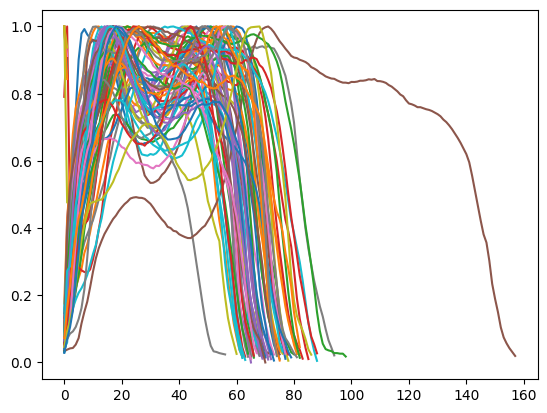

In [42]:
steps = {}
minVal = 30
for key, value in records.items():
    record = value['data1']
    idx = record.index[record.Force_Right < minVal].tolist()[0] + 1
    start = record[idx:].index[record.Force_Right[idx:] > minVal].tolist()[0]
    end = record[start:].index[record[start:].Force_Right < minVal].tolist()[0]
    step = record.Force_Right[start:end+1].tolist()
    steps[key] = [x / max(step) for x in step]

parkinsons = []
healthys = []
for key in steps:
    hoehnYahr = patients[patients['ID'] == key]['HoehnYahr'].values[0]
    parkinsons.append(key) if hoehnYahr > 0 else healthys.append(key)
    

plt.figure()
for key in parkinsons:
    plt.plot(steps[key])
plt.show()

plt.figure()
for key in healthys:
    plt.plot(steps[key])
plt.show()

#### Prezentacja typów falek

c:\Python38\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


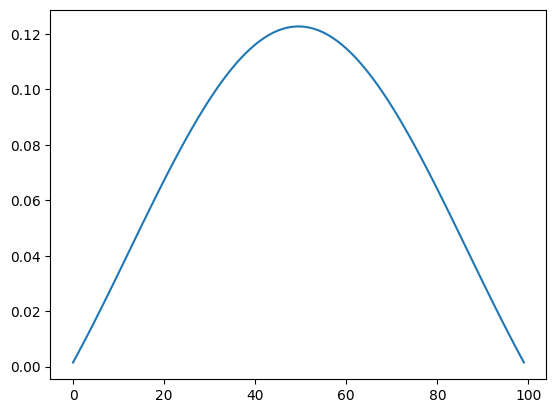

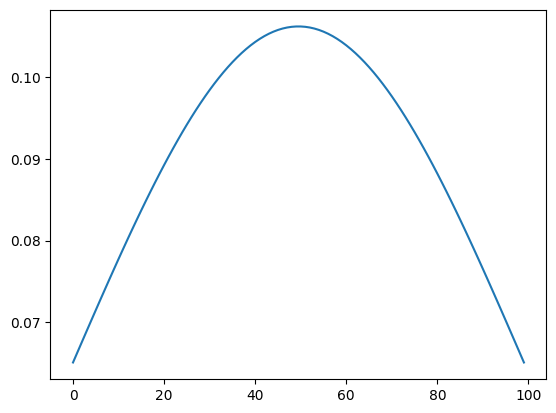

In [49]:
from scipy import signal
import matplotlib.pyplot as plt


points = 100
a = 50
w = 0

plt.figure()
vec_ricker = signal.ricker(points, a)
plt.plot(vec_ricker)

plt.savefig("plots/wavelet-type-ricker.pdf", format="pdf", bbox_inches="tight")

plt.figure()
vec_morlet2 = signal.morlet2(points, a, w)
plt.plot(vec_morlet2)

plt.savefig("plots/wavelet-type-morlet.pdf", format="pdf", bbox_inches="tight")


#### Wykresy transfomaty falkowej

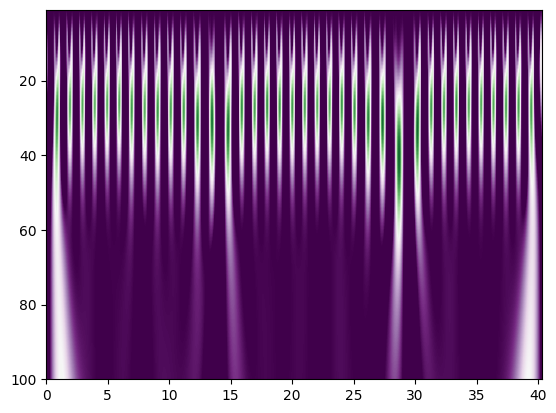

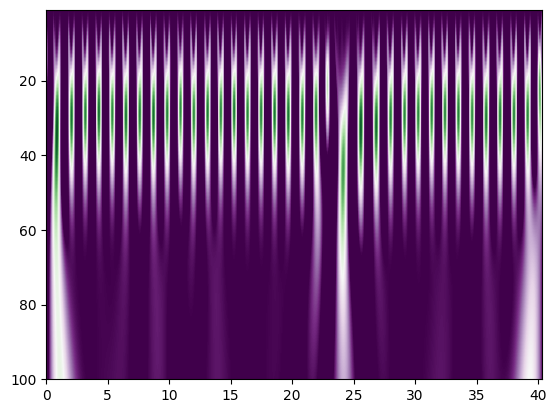

In [58]:
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np

healthy_patient_id = "GaCo16"
parkinson_patient_id = "GaPt26"

healthy_record = records[healthy_patient_id]["data1"]
parkinson_record = records[parkinson_patient_id]["data1"]

sample_number = 4034

y_healthy = healthy_record.Force_Left.head(sample_number) 
x_healthy = healthy_record.Time.head(sample_number)

y_parkinson = parkinson_record.Force_Left.head(sample_number)
x_parkinson = parkinson_record.Time.head(sample_number)

width = 100
widths = np.arange(1, width)
cwtmatr = signal.cwt(y_healthy, signal.ricker, widths, dtype='float64')
plt.figure()
plt.imshow(cwtmatr, extent=[0, x_healthy.values[-1], width, 1], cmap='PRGn', aspect='auto', vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).min())
plt.savefig("plots/healthy-wavelet.pdf", format="pdf", bbox_inches="tight")

widths = np.arange(1, width)
cwtmatr = signal.cwt(y_parkinson, signal.ricker, widths, dtype='float64')
plt.figure()
plt.imshow(cwtmatr, extent=[0, x_parkinson.values[-1], width, 1], cmap='PRGn', aspect='auto', vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).min())
plt.savefig("plots/parkinson-wavelet.pdf", format="pdf", bbox_inches="tight")

Porównanie tranformaty falkowej morleta i rickera

c:\Python38\lib\site-packages\scipy\signal\_wavelets.py:470: ComplexWarning: Casting complex values to real discards the imaginary part
  output[ind] = convolve(data, wavelet_data, mode='same')


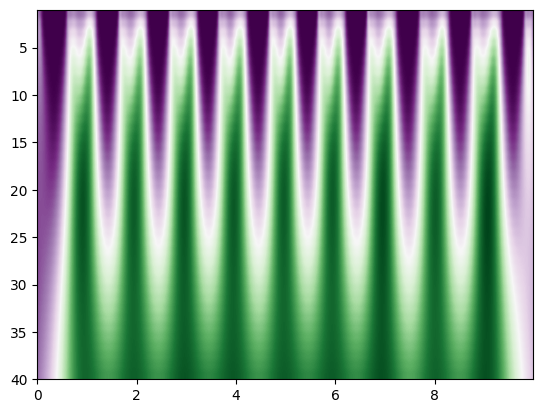

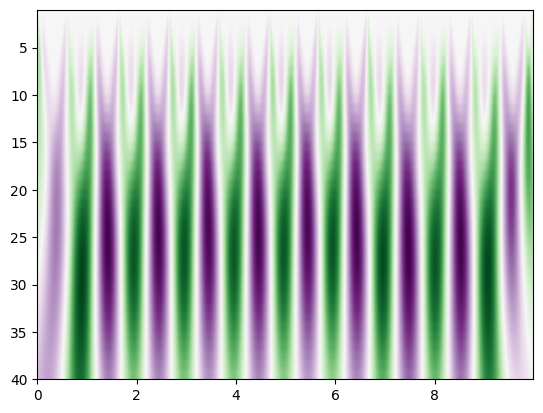

In [69]:
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np

healthy_patient_id = "GaCo16"
parkinson_patient_id = "GaPt26"

healthy_record = records[healthy_patient_id]["data1"]

# sample_number = 4034
sample_number = 1000

y_healthy = healthy_record.Force_Left.head(sample_number)
x_healthy = healthy_record.Time.head(sample_number)


width = 40

w = 0
widths = np.arange(1, width)
cwtmatr = signal.cwt(y_healthy, signal.morlet2, widths, dtype='float64', w=w)

plt.figure()
plt.imshow(cwtmatr, extent=[0, x_healthy.values[-1], width, 1], cmap='PRGn', aspect='auto', vmax=cwtmatr.max(), vmin=cwtmatr.min())
plt.savefig("plots/healthy-morlet.pdf", format="pdf", bbox_inches="tight")

widths = np.arange(1, width)
cwtmatr = signal.cwt(y_healthy, signal.ricker, widths, dtype='float64')
plt.figure()
plt.imshow(cwtmatr, extent=[0, x_healthy.values[-1], width, 1], cmap='PRGn', aspect='auto', vmax=cwtmatr.max(), vmin=cwtmatr.min())
plt.savefig("plots/healthy-ricker.pdf", format="pdf", bbox_inches="tight")

### Klasyfikacja

#### Tworzenie obrazów do klasyfikacji

In [70]:
cond = True
if cond:
    width = 40
    widths = np.arange(1, width)
    sample_number = 1000
    w = 0.0
    for id, value in records.items():
        print(f'Processing ID = {id}')
        hoehnYahr = patients[patients['ID'] == id]['HoehnYahr'].values[0]
        parkinson = 'Parkinson' if hoehnYahr > 0 else 'Healthy'
        hoehnYahr = hoehnYahr if hoehnYahr > 0 else 0.0

        sensors = [
            (lambda x: x.L1, "L1"),
            (lambda x: x.L2, "L2"),
            (lambda x: x.L3, "L3"),
            (lambda x: x.L4, "L4"),
            (lambda x: x.L5, "L5"),
            (lambda x: x.L6, "L6"),
            (lambda x: x.L7, "L7"),
            (lambda x: x.L8, "L8"),
            # (lambda x: x.Force_Left, "Force_Left"),
            (lambda x: x.R1, "R1"),
            (lambda x: x.R2, "R2"),
            (lambda x: x.R3, "R3"),
            (lambda x: x.R4, "R4"),
            (lambda x: x.R5, "R5"),
            (lambda x: x.R6, "R6"),
            (lambda x: x.R7, "R7"),
            (lambda x: x.R8, "R8"),
            # (lambda x: x.Force_Right, "Force_Right")
            ]
        record = value['data1']
        x = record.Time.head(sample_number)

        for sensor in sensors:
            func, name = sensor
            y = func(record).head(sample_number)
            # cwtFunc = lambda: signal.cwt(y, signal.morlet2, widths, dtype='float64', w=w)
            cwtFunc = lambda: signal.cwt(y, signal.ricker, widths, dtype='float64')
            utils.createWaveletPlot(x, cwtFunc, parkinson, id, name)
            utils.createWaveletPlot(x, cwtFunc, hoehnYahr, id, name)

Processing ID = JuPt03
Processing ID = GaPt15
Processing ID = GaCo08
Processing ID = GaPt14
Processing ID = JuPt01
Processing ID = JuPt28
Processing ID = JuCo06
Processing ID = GaPt24
Processing ID = SiCo22
Processing ID = JuPt29
Processing ID = SiCo16
Processing ID = JuCo19
Processing ID = GaPt28
Processing ID = JuPt24
Processing ID = SiCo11
Processing ID = GaPt08
Processing ID = GaPt20
Processing ID = GaCo09
Processing ID = GaPt26
Processing ID = SiPt29
Processing ID = SiCo01
Processing ID = SiPt14
Processing ID = SiPt18
Processing ID = SiCo28
Processing ID = SiPt20
Processing ID = JuPt06
Processing ID = JuCo04
Processing ID = GaPt31
Processing ID = SiPt38
Processing ID = JuCo24
Processing ID = GaPt19
Processing ID = JuPt20
Processing ID = GaCo13
Processing ID = SiCo03
Processing ID = JuPt23
Processing ID = SiCo24
Processing ID = SiCo04
Processing ID = JuPt04
Processing ID = GaPt09
Processing ID = JuPt09
Processing ID = JuPt15
Processing ID = GaCo01
Processing ID = JuPt17
Processing 

#### Przygotowanie zbiorów danych

In [71]:
import csv
import os
import pickle

cond = True
if cond:
    type = "Binary"
    wavelet = "Ricker"
    directory = f"{os.getcwd()}/Datasets/{type}/{wavelet}"
    output = f"{os.getcwd()}/Datasets/{type}/{wavelet}"
    split = "70/20/10"
    
    train_f = open(f"{output}_train", 'w', encoding='UTF8', newline='')
    train_writer = csv.writer(train_f)
    test_f = open(f"{output}_test", 'w', encoding='UTF8', newline='')
    test_writer = csv.writer(test_f)
    validation_f = open(f"{output}_validation", 'w', encoding='UTF8', newline='')
    validation_writer = csv.writer(validation_f)

    s = split.split('/')
    splits = {
        "train": int(s[0]),
        "test": int(s[1]),
        "validation": int(s[2])
    }

    classes = {}
    for idx, c in enumerate(os.listdir(directory)):
        classes[idx] = c

        images = os.listdir(f"{directory}/{c}")
        class_count = len(images)
        for imidx, filename in enumerate(images):
            row = [f"{c}/{filename}", idx]
            if imidx < class_count * splits["train"] / 100:
                train_writer.writerow(row)
            elif imidx < class_count * (splits["train"] + splits["test"]) / 100:
                test_writer.writerow(row)
            else:
                validation_writer.writerow(row)

    with open(f"{output}_utils", 'wb') as f:
        pickle.dump(classes, f)

    train_f.close()
    test_f.close()
    validation_f.close()

#### Uczenie sieci

In [72]:
import LearningUtils
import importlib
import os
import ModelTrainer
from torchvision import models
from torchsummary import summary
importlib.reload(ModelTrainer)
importlib.reload(LearningUtils)

cond = True
if cond:
    imgdir = f"{os.getcwd()}/Datasets/Binary/Ricker"

    classes = LearningUtils.get_classes(imgdir)
    train_data_loader, validation_data_loader, test_data_loader = LearningUtils.prepare_data(imgdir)
    model_trainer = ModelTrainer.ModelTrainer(classes)
    resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    # summary(resnet, (3, 224, 224))
    model = model_trainer.train_resnet(resnet, train_data_loader, validation_data_loader, num_epochs=50)
    model.eval()
    LearningUtils.predict_image(model, test_data_loader, classes)

Epoch 0/49
----------


KeyboardInterrupt: 